# Auriemma Valerio 0334683

### Importazione delle librerie

Questa cella di codice importa le librerie necessarie per il progetto di classificazione di Emnist. Ecco un riassunto di ciascuna libreria importata:

- **tensorflow**: Utilizzato per costruire e addestrare reti neurali.
- **numpy**: Fornisce supporto per operazioni matematiche efficienti su array.
- **pandas**: Utilizzato per manipolare e analizzare dati tabulari.
- **matplotlib**: Utilizzato per la visualizzazione dei dati.
- **os**: Fornisce funzionalità per interagire con il sistema operativo.

Inoltre, vengono importati diversi moduli da Keras, un'API di alto livello per la costruzione di modelli neurali:
- **RandomNormal**, **he_normal**, **glorot_normal**: Inizializzatori per i pesi dei neuroni.
- **Dropout**: Una tecnica di regolarizzazione per reti neurali.
- **regularizers**: Utilizzato per applicare la regolarizzazione ai pesi dei modelli.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from keras.initializers import RandomNormal
from keras.initializers import he_normal
from keras.initializers import glorot_normal

from keras.layers import Dropout

from keras import regularizers

### Caricamento dei dati

Carico i dati dal file "emnist-letters.csv" utilizzando Pandas e salvandoli in `df`.  

In [2]:
df = pd.read_csv("emnist-letters.csv")
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order = "F")
y = df.iloc[:,0].to_numpy()-1

### Impostazione del seed per la riproducibilità e la configurazione della visualizzazione dei grafici

Imposto il seed per generare numeri casuali, lo imposto per tutti e due i generatori:  

- Generatore di NumPy
- Generatore di TensorFlow

Inoltre, stiamo configurando la visualizzazione dei grafici per renderli più leggibili e piacevoli:

- `%matplotlib inline`: Questo comando magico di JupyterLab consente di visualizzare i grafici direttamente nel notebook.
- `mpl.rc('axes', labelsize=14)`: Imposta la dimensione del testo dell'etichetta degli assi a 14.

In [3]:
# Imposto il seed per generare codice casuale
np.random.seed(42)
tf.random.set_seed(42)
# To plot pretty figures
%matplotlib inline

mpl.rc('axes', labelsize = 14)

In [4]:
X.shape

(88799, 28, 28)

- La prima dimensione rappresenta il numero totale di immagini nel dataset.
- Le dimensioni successive rappresentano l'altezza e la larghezza di ciascuna immagine, rispettivamente.


### Preparazione dei Dati di Addestramento, Validazione e Test

In questa cella di codice, stiamo preparando i dati per l'addestramento, la validazione e il test del modello. Ecco come:

- **Training Set** = 81799 campioni
- **Validation Set** = 5000 campioni
- **Test Set** = 2000 campioni

In [5]:
X_test, X_valid, X_train = X[:2000] / 255., X[2000:7000]/255., X[7000:] / 255.
y_test, y_valid, y_train = y[:2000], y[2000:7000], y[7000:]

# Aggiungi rumore gaussiano ai dati
noise = np.random.normal(0, 0.2, X_train.shape)  # Genera rumore gaussiano
X_train_wnoise =  X_train + noise  # Aggiungi rumore ai dati

plt.imshow(X_train[0], cmap = "binary")
plt.axis('on')
plt.show()

# Reti Neurali Completamente Connesse  
Ora andiamo a lavorare con le reti con soli strati densi, sappiamo che questo lavoro non è ottimale per la loro struttura ma proveremo ad analizzare più di qualche aspetto studiato durante il corso.
## Test con EarlyStopping
 Andiamo a fare i primi test per poter estrapolare da essi le scelte sulle reti che possano essere significative. Sono stati fatte delle scelte su di essi:  
- In questi primi test la rete è stata addestrata finché l'algoritmo di EarlyStopping (tolleranza = 12) non andava ad arrestare l'algoritmo;
- Non sono stati utilizzati altri metodi di regolarizzazione dato che ritenuto sufficiente la prevenzione sull'overfitting da parte di EarlyStopping;
- Data la presenza dell'EarlyStopping il codice è stato fatto girare con un numero di epoche molto alto dato che l'obiettivo è che si arrestasse solo e solamente con EarlyStopping;


|           | Strati |    Neuroni     | Foo. attivazioni      |     Epoche    | Init.Pesi | Ottimizzazione | Regolarizzazione | AccVld | AccTst|
|-----------|--------|----------------|-----------------------|---------------|-----------|----------------|------------------|--------|-------|
| **1°Test**|   3    | {300, 100, 26} | {ReLU, ReLU, softmax} | EarlyStopping |     He    |     Adam       |       -          | 90.3%  |89.4%  |
| **2°Test**|   3    | {300, 100, 26} | {sigm, sigm, softmax} | EarlyStopping |     He    |     Adam       |       -          | 90.8%  |89.0%  |
| **3°Test**|   3    | {300, 100, 26} | {ReLU, ReLU, softmax} | EarlyStopping |     He    |      SGD       |       -          | 90.2%  |89.6%  |
| **4°Test**|   3    | {300, 100, 26} | {ReLU, ReLU, softmax} | EarlyStopping |   Glorot  |     Adam       |       -          | 90.7%  |90.4%  |
| **5°Test**|   3    | {300, 100, 26} | {sigm, sigm, softmax} | EarlyStopping |   Glorot  |     SGD        |       -          | 89.8%  |88.1%  |
| **6°Test**|   4    |{450,230,75,26} |{ReLU,ReLU,ReLU,softmax}| EarlyStopping |     He    |     Adam       |       -          | 89.6%  |89.5% |  

Notiamo che l'unica scelta significativa tra tutti i test che sono stati fatti è quella nel 4°Test andando a fare la scelta di inizializzazione dei pesi da He a Glorot.  
Un altra nota importante da fare è sul 5°Test, l'algoritmo è stato bloccato alla 100esima epoca (fissata come massima) di addestramento, EarlyStopping non è riuscito a convergere.

## Senza EarlyStopping
Adesso andremo a cambiare le tecniche di regolarizzazione per vedere come possono influenzare le performance della rete:
- Qui andiamo a cambiare i dati riguardanti la penultima colonna ovvero metteremo a confontro l'accuratezza del TrainingSet con quella del ValidationSet al variare dei vari metodi di regolarizzazione.
- L'addestramento con la NoiseInjection è stato fatto sul TrainingSet originale ma aggiungendo un rumore Gaussiano con media = 0 e varianza = 0.2;
- Il dropout è stato applicato con una probabilità del 80% sullo strato d'ingresso e con il 50% sugli strati nascosti nel 5° test mentre con una probabilita del 40% sullo strato d'ingresso e 20% sugli strati nascosti nel 6°test.

|           | Strati |    Neuroni     | Foo. attivazioni        |     Epoche  | Init.Pesi | Ottimizzazione | Regolarizzazione | AccTrn | AccTst|
|-----------|--------|----------------|-------------------------|-------------|-----------|----------------|------------------|--------|-------|
| **1°Test**|   4    |{450,250,100,26}|{ReLU,ReLU,ReLU,softmax} |      30     |     He    |     SGD        |       -          | 96.8%  |88.3%  |
| **2°Test**|   4    |{450,250,100,26}|{ReLU,ReLU,ReLU,softmax} |      30     |     He    |     SGD        |    L2(0.001)     | 92.5%  |88.9%  |
| **3°Test**|   4    |{450,250,100,26}|{ReLU,ReLU,ReLU,softmax} |      30     |     He    |     SGD        |    L2(0.01)      | 76.7%  |74.7%  |
| **4°Test**|   4    |{450,250,100,26}|{ReLU,ReLU,ReLU,softmax} |      30     |     He    |     SGD        |NoiseInj(gauss0.2)| 99.8%  |89.3%  |
| **5°Test**|   4    |{450,250,100,26}|{ReLU,ReLU,ReLU,softmax} |      30     |     He    |     SGD        |Dropout (0.8, 0.5)| 50.4%  |69.9%  |
| **6°Test**|   4    |{450,250,100,26}|{ReLU,ReLU,ReLU,softmax} |      30     |     He    |     SGD        |Dropout (0.4, 0.2)| 84.6%  |89.6%  |

Si noti come il miglior risultato ottenuto è stato ottenuto andando ad utilizzare la NoiseInjection e il dropout.  
Il dropout con le percentuali indicate dal testo di riferimento (0.8 e 0.5) si è rivelato troppo aggressivo nei confronti della rete, andando a causare il fenomento di underfitting.
L'utilizzo di metodi di regolarizzazione porta all'introduzione di uno o più hyperparametri, di cui tuning errato porta a underfitting della rete.

- **N.B!** Tali metodi di regolarizzazione possono essere utilizzati anche insieme, ciò però comporta ad una maggiore attenzione nel tuning dei multipli hyperparametri caratterizzanti i metodi stessi.


In [6]:
# kernel_initializer = he_normal()
# kernel_initializer = glorot_normal()
# kernel_initializer = RandomNormal(mean=0.0, stddev=0.01)

# Nota la regolarizzazione mi porta ad un risultato peggiore che senza

# Ho uno strato di Input di 784, cerco di costruire un qualcosa ad imbuto

NN1 = keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(300, activation = "relu", kernel_regularizer=regularizers.l2(0.00), kernel_initializer = glorot_normal()),
        tf.keras.layers.Dense(100, activation = "relu", kernel_regularizer=regularizers.l2(0.00), kernel_initializer = glorot_normal()),
        tf.keras.layers.Dense(26, activation = "softmax", kernel_regularizer=regularizers.l2(0.00), kernel_initializer = glorot_normal()),
])

In [93]:
NN1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_56 (Dense)            (None, 450)               353250    
                                                                 
 dense_57 (Dense)            (None, 250)               112750    
                                                                 
 dense_58 (Dense)            (None, 100)               25100     
                                                                 
 dense_59 (Dense)            (None, 26)                2626      
                                                                 
Total params: 493726 (1.88 MB)
Trainable params: 493726 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
NN1.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [9]:
history = NN1.fit(X_train, y_train, epochs = 100,
                    validation_data=(X_valid, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=12)])

#history = NN1.fit(X_train, y_train, epochs = 30,
#                    validation_data=(X_valid, y_valid))

Epoch 1/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.2846 - accuracy: 0.9052 - val_loss: 0.3125 - val_accuracy: 0.8992
Epoch 2/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.2409 - accuracy: 0.9172 - val_loss: 0.3155 - val_accuracy: 0.9048
Epoch 3/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.2140 - accuracy: 0.9254 - val_loss: 0.3039 - val_accuracy: 0.9044
Epoch 4/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.1924 - accuracy: 0.9318 - val_loss: 0.3010 - val_accuracy: 0.9074
Epoch 5/100
2557/2557 [==============================] - 5s 2ms/step - loss: 0.1757 - accuracy: 0.9359 - val_loss: 0.3374 - val_accuracy: 0.9044
Epoch 6/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.1587 - accuracy: 0.9407 - val_loss: 0.3483 - val_accuracy: 0.9052
Epoch 7/100
2557/2557 [==============================] - 6s 2ms/step - loss: 0.1486 - accuracy: 0.9441 - val_loss: 0.3488 - val_ac

In [10]:
test_loss, test_accuracy = NN1.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 2ms/step - loss: 0.4962 - accuracy: 0.9045
Test Loss: 0.4962226450443268
Test Accuracy: 0.9045000076293945


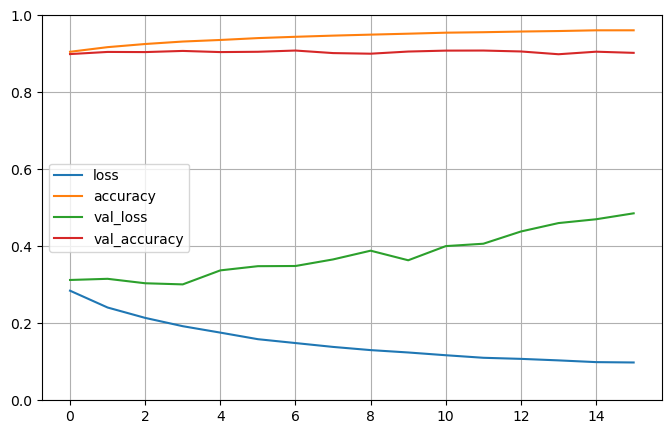

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Noise Injection

In [95]:
history_wnoise = NN1.fit(X_train_wnoise, y_train, epochs = 30,
                    validation_data = (X_valid, y_valid))

Epoch 1/30
2557/2557 [==============================] - 6s 2ms/step - loss: 1.4482 - accuracy: 0.5825 - val_loss: 0.9453 - val_accuracy: 0.7056
Epoch 2/30
2557/2557 [==============================] - 5s 2ms/step - loss: 0.8305 - accuracy: 0.7512 - val_loss: 0.6364 - val_accuracy: 0.8092
Epoch 3/30
2557/2557 [==============================] - 5s 2ms/step - loss: 0.6450 - accuracy: 0.8037 - val_loss: 0.5396 - val_accuracy: 0.8364
Epoch 4/30
2557/2557 [==============================] - 5s 2ms/step - loss: 0.5363 - accuracy: 0.8356 - val_loss: 0.4557 - val_accuracy: 0.8578
Epoch 5/30
2557/2557 [==============================] - 5s 2ms/step - loss: 0.4631 - accuracy: 0.8571 - val_loss: 0.4554 - val_accuracy: 0.8578
Epoch 6/30
2557/2557 [==============================] - 5s 2ms/step - loss: 0.4074 - accuracy: 0.8721 - val_loss: 0.3965 - val_accuracy: 0.8736
Epoch 7/30
2557/2557 [==============================] - 5s 2ms/step - loss: 0.3616 - accuracy: 0.8867 - val_loss: 0.3939 - val_accuracy:

In [96]:
test_loss, test_accuracy = NN1.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 1ms/step - loss: 0.4275 - accuracy: 0.8940
Test Loss: 0.4274803400039673
Test Accuracy: 0.8939999938011169


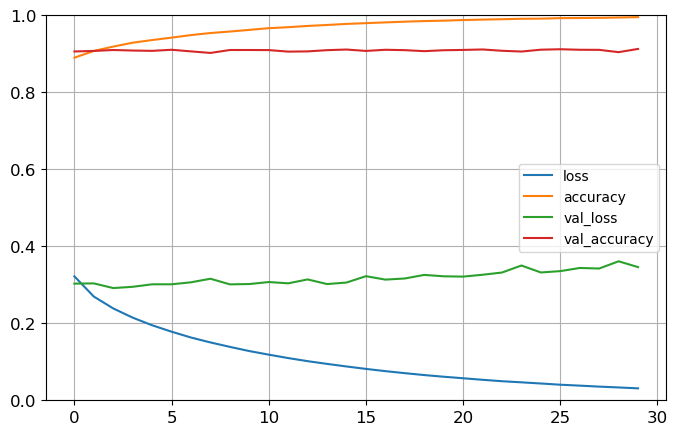

In [160]:
pd.DataFrame(history_wnoise.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Dropout

In [104]:
NN_drop = keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        Dropout(0.4),  # Applico il dropout all' 80%
        tf.keras.layers.Dense(450, activation = "relu", kernel_initializer = he_normal()),
        Dropout(0.2),  # Applica dropout al 50%
        tf.keras.layers.Dense(250, activation = "relu", kernel_initializer = he_normal()),
        Dropout(0.2),  # Applica dropout al 50%
        tf.keras.layers.Dense(100, activation = "relu", kernel_initializer = he_normal()),
        Dropout(0.2),  # Applica dropout al 50%
        tf.keras.layers.Dense(26, activation = "softmax", kernel_initializer = he_normal()),
])

In [105]:
NN_drop.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "SGD",
              metrics = ["accuracy"])

In [106]:
history_drop = NN_drop.fit(X_train, y_train, epochs = 30,
                    validation_data=(X_valid, y_valid))
                  

Epoch 1/30
2557/2557 [==============================] - 8s 3ms/step - loss: 2.1250 - accuracy: 0.3695 - val_loss: 1.1653 - val_accuracy: 0.6572
Epoch 2/30
2557/2557 [==============================] - 7s 3ms/step - loss: 1.4031 - accuracy: 0.5719 - val_loss: 0.8883 - val_accuracy: 0.7340
Epoch 3/30
2557/2557 [==============================] - 7s 3ms/step - loss: 1.1812 - accuracy: 0.6350 - val_loss: 0.7377 - val_accuracy: 0.7798
Epoch 4/30
2557/2557 [==============================] - 7s 3ms/step - loss: 1.0397 - accuracy: 0.6784 - val_loss: 0.6406 - val_accuracy: 0.8094
Epoch 5/30
2557/2557 [==============================] - 7s 3ms/step - loss: 0.9515 - accuracy: 0.7042 - val_loss: 0.5795 - val_accuracy: 0.8280
Epoch 6/30
2557/2557 [==============================] - 7s 3ms/step - loss: 0.8861 - accuracy: 0.7246 - val_loss: 0.5354 - val_accuracy: 0.8388
Epoch 7/30
2557/2557 [==============================] - 7s 3ms/step - loss: 0.8353 - accuracy: 0.7391 - val_loss: 0.4966 - val_accuracy:

In [107]:
test_loss, test_accuracy = NN_drop.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 1ms/step - loss: 0.3072 - accuracy: 0.8960
Test Loss: 0.3071887195110321
Test Accuracy: 0.8960000276565552


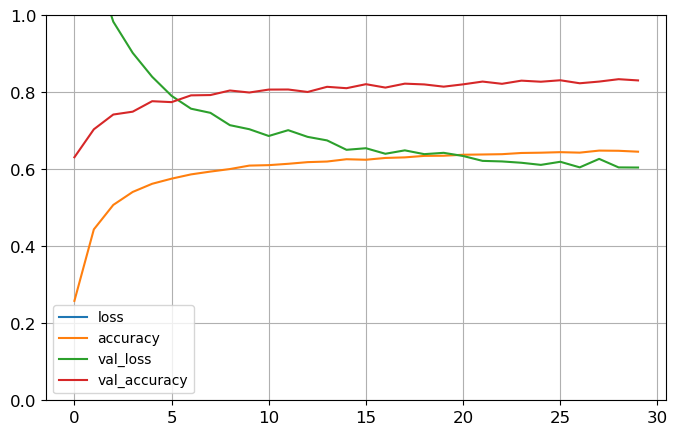

In [169]:
pd.DataFrame(history_drop.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Reti Convoluzionali
Come sappiamo esse sono utilizzate proprio per andare a lavorare con dati che hanno una struttura bidimensionale e vedremo come i risultati di tali reti sono migliori rispetto alle reti completamente connesse.

In [6]:
X_train2 = X_train.reshape(-1, 28, 28, 1) # single channel
X_valid2 = X_valid.reshape(-1, 28, 28, 1)
X_test2 = X_test.reshape(-1,28,28,1)

Iniziamo con il testare la LeNet-5.

## LeNet-5

In [7]:
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(26, activation="softmax")])


lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lenet.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)              

In [97]:
history_lenet = lenet.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.0682 - accuracy: 0.9729 - val_loss: 0.2419 - val_accuracy: 0.9316
Epoch 2/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0670 - accuracy: 0.9737 - val_loss: 0.2467 - val_accuracy: 0.9334
Epoch 3/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0653 - accuracy: 0.9738 - val_loss: 0.2524 - val_accuracy: 0.9324
Epoch 4/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0642 - accuracy: 0.9745 - val_loss: 0.2606 - val_accuracy: 0.9320
Epoch 5/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0625 - accuracy: 0.9751 - val_loss: 0.2705 - val_accuracy: 0.9238
Epoch 6/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0620 - accuracy: 0.9748 - val_loss: 0.2516 - val_accuracy: 0.9354
Epoch 7/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.0605 - accuracy: 0.9750 - val_loss: 0.2588 - val_accuracy:

In [98]:
test_loss, test_accuracy = lenet.evaluate(X_test2, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.9280
Test Loss: 0.2832984924316406
Test Accuracy: 0.9279999732971191


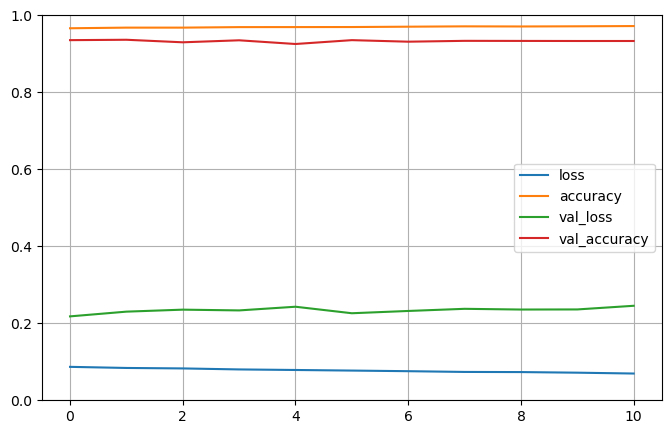

In [87]:
pd.DataFrame(history_lenet.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Ora proviamo a variare il numero e le dimensioni del kerneel negli strati convoluzionali, inoltre proviamo a sostituire la sigmoide con la relu

In [99]:
CNN = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=4, kernel_size=7, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=12, kernel_size=5,activation='relu',padding = 'same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])


CNN.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

CNN.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 28, 28, 4)         200       
                                                                 
 average_pooling2d_69 (Aver  (None, 14, 14, 4)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_106 (Conv2D)         (None, 14, 14, 12)        1212      
                                                                 
 average_pooling2d_70 (Aver  (None, 7, 7, 12)          0         
 agePooling2D)                                                   
                                                                 
 flatten_47 (Flatten)        (None, 588)               0         
                                                                 
 dense_145 (Dense)           (None, 120)             

In [100]:
history_c = CNN.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.6273 - accuracy: 0.8045 - val_loss: 0.3295 - val_accuracy: 0.8918
Epoch 2/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2945 - accuracy: 0.9020 - val_loss: 0.2762 - val_accuracy: 0.9090
Epoch 3/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2383 - accuracy: 0.9189 - val_loss: 0.2306 - val_accuracy: 0.9232
Epoch 4/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2087 - accuracy: 0.9285 - val_loss: 0.2205 - val_accuracy: 0.9290
Epoch 5/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1870 - accuracy: 0.9335 - val_loss: 0.2278 - val_accuracy: 0.9216
Epoch 6/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1711 - accuracy: 0.9381 - val_loss: 0.2125 - val_accuracy: 0.9290
Epoch 7/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.1552 - accuracy: 0.9437 - val_loss: 0.2169 - val_accuracy:

In [105]:
test_loss, test_accuracy = CNN.evaluate(X_test2, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 2ms/step - loss: 0.2803 - accuracy: 0.9290
Test Loss: 0.28025367856025696
Test Accuracy: 0.9290000200271606


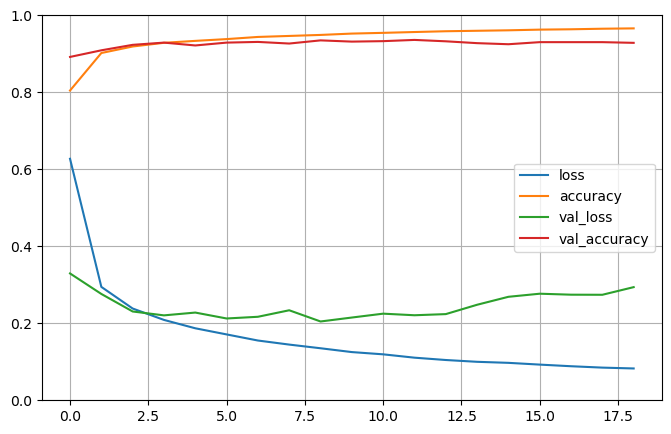

In [102]:
pd.DataFrame(history_c.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Ora proviamo ad a cambiare il pooling con un max Pooling

In [103]:
CNN1 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=4, kernel_size=7, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=12, kernel_size=5,activation='relu',padding = 'same'),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])


CNN1.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

CNN1.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 28, 28, 4)         200       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_108 (Conv2D)         (None, 14, 14, 12)        1212      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 7, 7, 12)          0         
 ng2D)                                                           
                                                                 
 flatten_48 (Flatten)        (None, 588)               0         
                                                                 
 dense_148 (Dense)           (None, 120)             

In [104]:
history_c1 = CNN1.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.5987 - accuracy: 0.8133 - val_loss: 0.3319 - val_accuracy: 0.8886
Epoch 2/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2997 - accuracy: 0.8997 - val_loss: 0.2783 - val_accuracy: 0.9074
Epoch 3/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2486 - accuracy: 0.9156 - val_loss: 0.2361 - val_accuracy: 0.9204
Epoch 4/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2181 - accuracy: 0.9243 - val_loss: 0.2288 - val_accuracy: 0.9270
Epoch 5/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1978 - accuracy: 0.9301 - val_loss: 0.2504 - val_accuracy: 0.9188
Epoch 6/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1803 - accuracy: 0.9356 - val_loss: 0.2291 - val_accuracy: 0.9286
Epoch 7/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1678 - accuracy: 0.9401 - val_loss: 0.2238 - val_accuracy:

In [106]:
test_loss, test_accuracy = CNN1.evaluate(X_test2, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 2ms/step - loss: 0.3019 - accuracy: 0.9140
Test Loss: 0.30188876390457153
Test Accuracy: 0.9139999747276306


Notiamo come i risultati sono molto simili, allora proviamo ad appesantire la rete. Notare che se si aggiungono troppi strati convoluzionali andremo a perdere sempre di più le informazioni dell'imagine, andando a passare al blocco denso poche informazioni!


In [107]:
CNN2 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=12, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=18, kernel_size=3,activation='relu',padding = 'same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=24, kernel_size=3,activation='relu',padding = 'same'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])


CNN2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

CNN2.summary()


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 28, 28, 12)        312       
                                                                 
 average_pooling2d_71 (Aver  (None, 14, 14, 12)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_110 (Conv2D)         (None, 14, 14, 18)        1962      
                                                                 
 average_pooling2d_72 (Aver  (None, 7, 7, 18)          0         
 agePooling2D)                                                   
                                                                 
 conv2d_111 (Conv2D)         (None, 7, 7, 24)          3912      
                                                                 
 average_pooling2d_73 (Aver  (None, 3, 3, 24)        

In [108]:
history_c2 = CNN2.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
2557/2557 [==============================] - 11s 4ms/step - loss: 0.7074 - accuracy: 0.7797 - val_loss: 0.3500 - val_accuracy: 0.8878
Epoch 2/30
2557/2557 [==============================] - 9s 4ms/step - loss: 0.3254 - accuracy: 0.8929 - val_loss: 0.2886 - val_accuracy: 0.9030
Epoch 3/30
2557/2557 [==============================] - 9s 4ms/step - loss: 0.2598 - accuracy: 0.9120 - val_loss: 0.2373 - val_accuracy: 0.9206
Epoch 4/30
2557/2557 [==============================] - 9s 4ms/step - loss: 0.2268 - accuracy: 0.9232 - val_loss: 0.2079 - val_accuracy: 0.9276
Epoch 5/30
2557/2557 [==============================] - 10s 4ms/step - loss: 0.2060 - accuracy: 0.9295 - val_loss: 0.2140 - val_accuracy: 0.9282
Epoch 6/30
2557/2557 [==============================] - 10s 4ms/step - loss: 0.1889 - accuracy: 0.9340 - val_loss: 0.2186 - val_accuracy: 0.9272
Epoch 7/30
2557/2557 [==============================] - 10s 4ms/step - loss: 0.1763 - accuracy: 0.9371 - val_loss: 0.1996 - val_accur

In [109]:
test_loss, test_accuracy = CNN2.evaluate(X_test2, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9295
Test Loss: 0.22568105161190033
Test Accuracy: 0.9294999837875366


Proviamo solo a mettere uno strato convoluzionale.

In [110]:
CNN3 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=10, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=3, strides=3),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(400, activation='relu'),
            tf.keras.layers.Dense(160, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])


CNN3.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

CNN3.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 28, 28, 10)        260       
                                                                 
 average_pooling2d_74 (Aver  (None, 9, 9, 10)          0         
 agePooling2D)                                                   
                                                                 
 flatten_50 (Flatten)        (None, 810)               0         
                                                                 
 dense_154 (Dense)           (None, 400)               324400    
                                                                 
 dense_155 (Dense)           (None, 160)               64160     
                                                                 
 dense_156 (Dense)           (None, 84)                13524     
                                                     

In [111]:
history_c3 = CNN3.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.5806 - accuracy: 0.8177 - val_loss: 0.3123 - val_accuracy: 0.8960
Epoch 2/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2819 - accuracy: 0.9051 - val_loss: 0.2789 - val_accuracy: 0.9062
Epoch 3/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.2224 - accuracy: 0.9236 - val_loss: 0.2354 - val_accuracy: 0.9220
Epoch 4/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1885 - accuracy: 0.9339 - val_loss: 0.2323 - val_accuracy: 0.9240
Epoch 5/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1639 - accuracy: 0.9409 - val_loss: 0.2372 - val_accuracy: 0.9212
Epoch 6/30
2557/2557 [==============================] - 9s 3ms/step - loss: 0.1433 - accuracy: 0.9468 - val_loss: 0.2285 - val_accuracy: 0.9298
Epoch 7/30
2557/2557 [==============================] - 8s 3ms/step - loss: 0.1273 - accuracy: 0.9524 - val_loss: 0.2432 - val_accuracy:

In [84]:
test_loss, test_accuracy = CNN3.evaluate(X_test2, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.9250
Test Loss: 0.30069729685783386
Test Accuracy: 0.925000011920929


Si noti come anche usare un solo strato convoluzionale porta a dei buoni risultati.